In [ ]:
from functools import partial

import numpy as np
import pandas as pd
from statsmodels.formula import api as smf

from matplotlib import pyplot as plt



plt.style.use('ggplot')
import seaborn as sns

In [2]:
class DataGenerator:
    def __init__(
        self,
        surrogate_distribution: callable,
        non_surrogate_distribution: callable,
        treatment_effect: float = 0.0,
        decay_factor: float = 1.0,
        total_panel: int = 52,
        control_group: bool = True
    ):
        self.surrogate_distribution = surrogate_distribution
        self.non_surrogate_distribution = non_surrogate_distribution
        self.treatment_effect = treatment_effect
        self.decay_factor = decay_factor
        
        self.total_panel = total_panel
        self.is_treatment_group = not control_group

        self.treatment_effects = np.array([treatment_effect*np.exp(-decay_factor*i) for i in range(total_panel)])
    
    def generate_data(self, n_samples:int = 1000, n_surrogates: int = 4):

        surrogate_data = np.clip(self.surrogate_distribution(size=(n_samples, n_surrogates)), a_min=0, a_max=np.inf)
        non_surrogate_data = np.clip(self.non_surrogate_distribution(size=(n_samples, self.total_panel - n_surrogates)), a_min=0, a_max=np.inf)

        full_panel_data = np.hstack([surrogate_data, non_surrogate_data])
        full_panel_data = full_panel_data + self.treatment_effects
        unit_total = full_panel_data.sum(axis=1)
        
        data = (
            pd.DataFrame(
                data = np.hstack([full_panel_data, unit_total.reshape(-1, 1)]), 
                columns=[f"surrogate_{i}" for i in range(n_surrogates)] + [f'non_surrogate_{i}' for i in range(n_surrogates, self.total_panel)] + ['unit_total']
            )
            .assign(
                treatment = int(self.is_treatment_group),
            )
        )
        return data

# Explain plots

In [3]:
np.random.seed(111)

In [4]:
training_dg = DataGenerator(
    surrogate_distribution=partial(np.random.normal, loc=0, scale=1),
    non_surrogate_distribution=partial(np.random.normal, loc=0, scale=1),
    treatment_effect=0,
    decay_factor=0.1,
    total_panel=2,
    control_group=True
)
training_data = training_dg.generate_data(n_samples=100, n_surrogates=1)

In [5]:
experiment_dg = DataGenerator(
    surrogate_distribution=partial(np.random.normal, loc=0, scale=1),
    non_surrogate_distribution=partial(np.random.normal, loc=0, scale=1),
    treatment_effect=0,
    decay_factor=0.1,
    total_panel=2,
    control_group=False
)
experiment_data = experiment_dg.generate_data(n_samples=100, n_surrogates=1)

In [6]:
x = 'surrogate_0'
y = 'unit_total'
xlab = 'Week 1 Potatoes'
ylab = 'Total Potatoes'
bounds = (
    (0, 10),
    (0, 10)
)

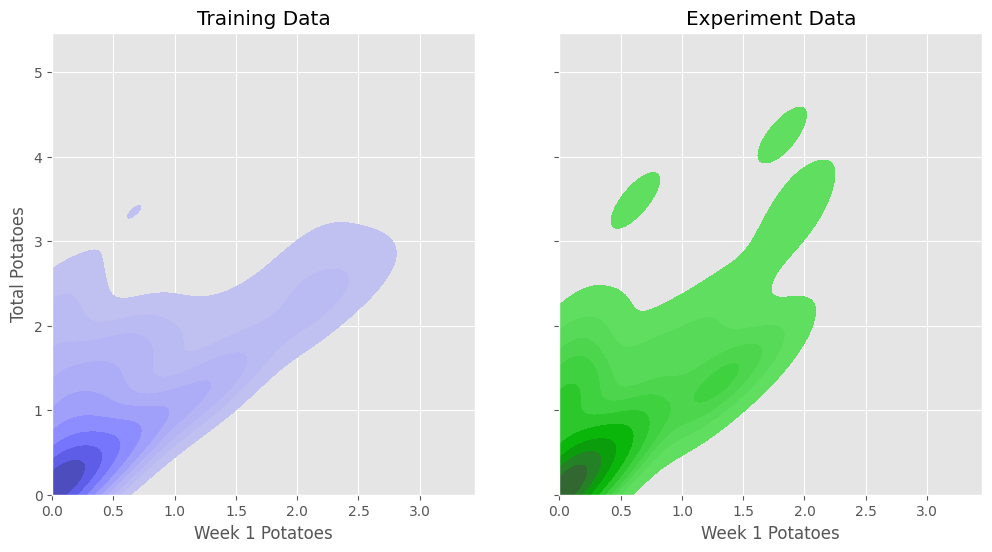

In [7]:
fig, ax = plt.subplots(figsize=(12, 6), ncols=2, sharey=True, sharex=True)
sns.kdeplot(
    data = training_data,
    x=x,
    y=y,
    clip = bounds,
    color='blue',
    fill = True,
    ax=ax[0]
)
ax[0].set_title('Training Data')
ax[0].set_xlabel(xlab)
ax[0].set_ylabel(ylab)
sns.kdeplot(
    data = experiment_data,
    x=x,
    y=y,
    clip = bounds,
    color = 'green',
    fill = True,
    ax=ax[1]
)
ax[1].set_title('Experiment Data')
ax[1].set_xlabel(xlab)
fig.savefig('../presentation/comparability_met_0.png')

## Change Distribution

In [8]:
control_dg = DataGenerator(
    surrogate_distribution=partial(np.random.normal, loc=0, scale=1),
    non_surrogate_distribution=partial(np.random.normal, loc=2, scale=1),
    treatment_effect=0,
    decay_factor=10,
    total_panel=2,
    control_group=True
)
treatment_dg = DataGenerator(
    surrogate_distribution=partial(np.random.normal, loc=0, scale=1),
    non_surrogate_distribution=partial(np.random.normal, loc=2, scale=1),
    treatment_effect=1,
    decay_factor=10,
    total_panel=2,
    control_group=False
)

control_data = control_dg.generate_data(n_samples=50, n_surrogates=1)
treatment_data = treatment_dg.generate_data(n_samples=50, n_surrogates=1)

experiment_data = pd.concat([control_data, treatment_data])

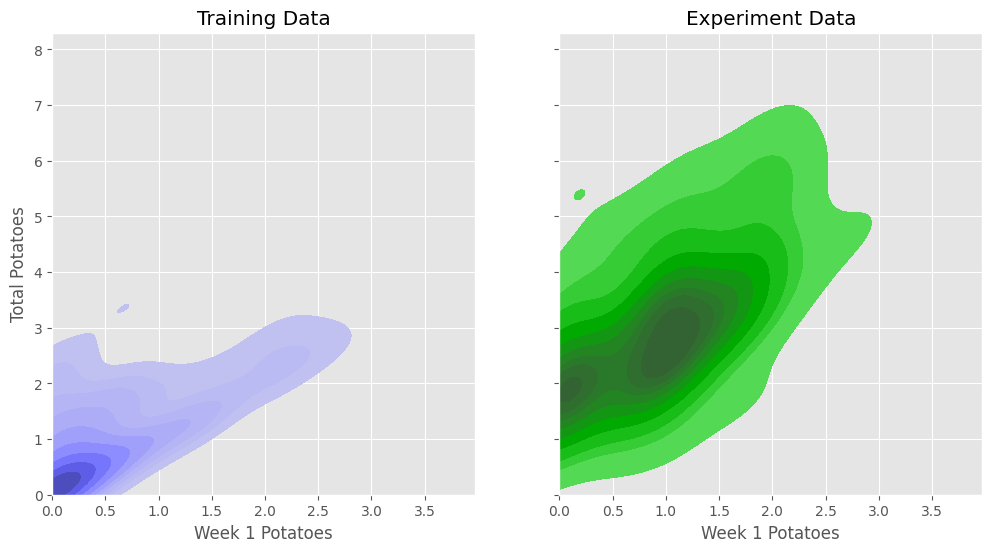

In [9]:
fig, ax = plt.subplots(figsize=(12, 6), ncols=2, sharey=True, sharex=True)
sns.kdeplot(
    data = training_data,
    x=x,
    y=y,
    clip = bounds,
    color='blue',
    fill = True,
    ax=ax[0]
)
ax[0].set_title('Training Data')
ax[0].set_xlabel(xlab)
ax[0].set_ylabel(ylab)
sns.kdeplot(
    data = experiment_data,
    x=x,
    y=y,
    clip = bounds,
    color = 'green',
    fill = True,
    ax=ax[1]
)
ax[1].set_title('Experiment Data')
ax[1].set_xlabel(xlab)
fig.savefig('../presentation/comparability_violation_1.png')

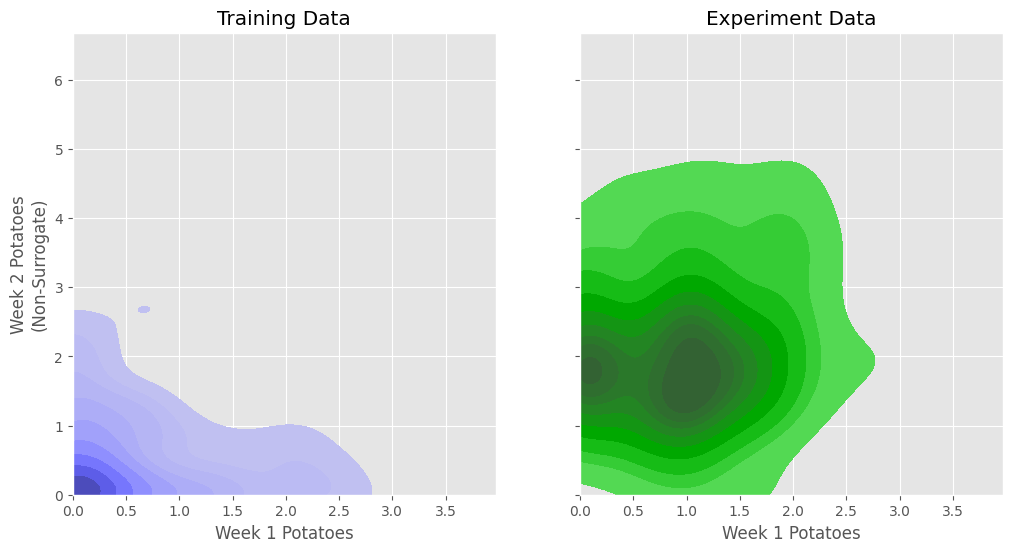

In [10]:
fig, ax = plt.subplots(figsize=(12, 6), ncols=2, sharey=True, sharex=True)
sns.kdeplot(
    data = training_data,
    x=x,
    y='non_surrogate_1',
    clip = bounds,
    color='blue',
    fill = True,
    ax=ax[0]
)
ax[0].set_title('Training Data')
ax[0].set_xlabel(xlab)
ax[0].set_ylabel('Week 2 Potatoes\n(Non-Surrogate)')
sns.kdeplot(
    data = experiment_data,
    x=x,
    y='non_surrogate_1',
    clip = bounds,
    color = 'green',
    fill = True,
    ax=ax[1]
)
ax[1].set_title('Experiment Data')
ax[1].set_xlabel(xlab)
fig.savefig('../presentation/comparability_violation_1_2.png')

In [173]:
## More detail

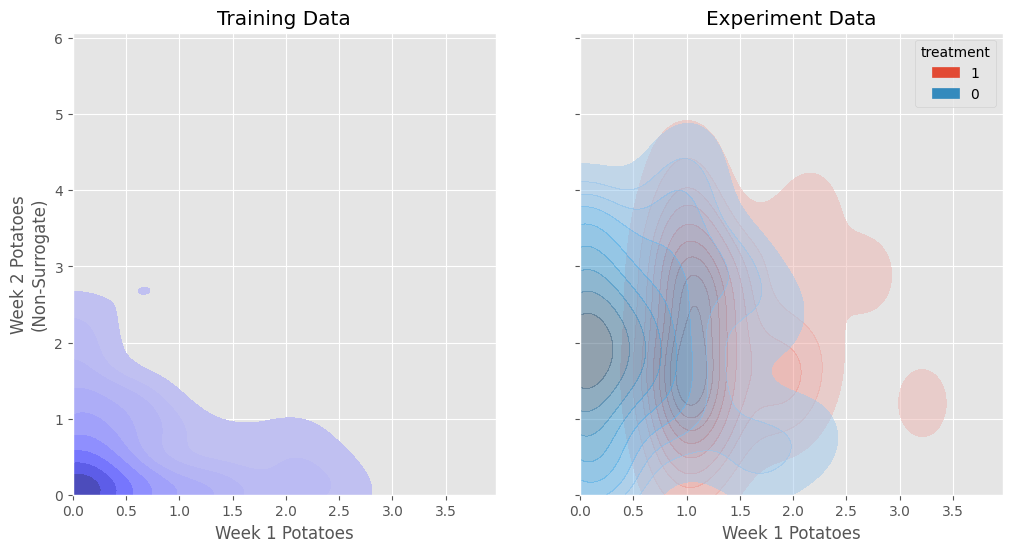

In [174]:
fig, ax = plt.subplots(figsize=(12, 6), ncols=2, sharey=True, sharex=True)
sns.kdeplot(
    data = training_data,
    x=x,
    y='non_surrogate_1',
    clip = bounds,
    color='blue',
    fill = True,
    ax=ax[0]
)
ax[0].set_title('Training Data')
ax[0].set_xlabel(xlab)
ax[0].set_ylabel('Week 2 Potatoes\n(Non-Surrogate)')
sns.kdeplot(
    data = experiment_data,
    x=x,
    y='non_surrogate_1',
    hue='treatment',
    clip = bounds,
    color = 'green',
    hue_order=[1, 0],
    fill = True,
    common_norm=False,
    ax=ax[1],
    alpha=0.5
)
ax[1].set_title('Experiment Data')
ax[1].set_xlabel(xlab)
fig.savefig('../presentation/comparability_violation_1_3.png')

<Axes: xlabel='surrogate_0', ylabel='Density'>

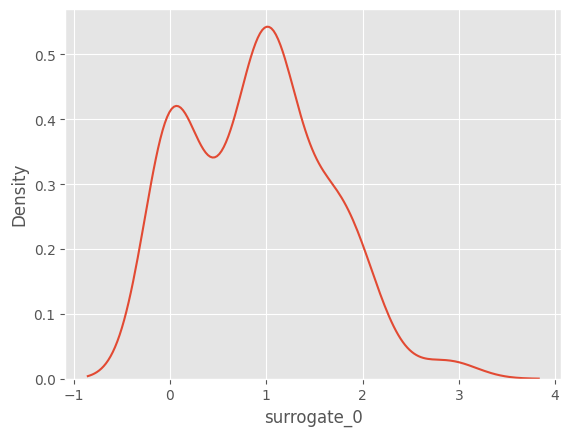

In [167]:
sns.kdeplot(
    data = experiment_data.loc[:, 'surrogate_0']
)

In [31]:
bounds

((0, 10), (0, 10))

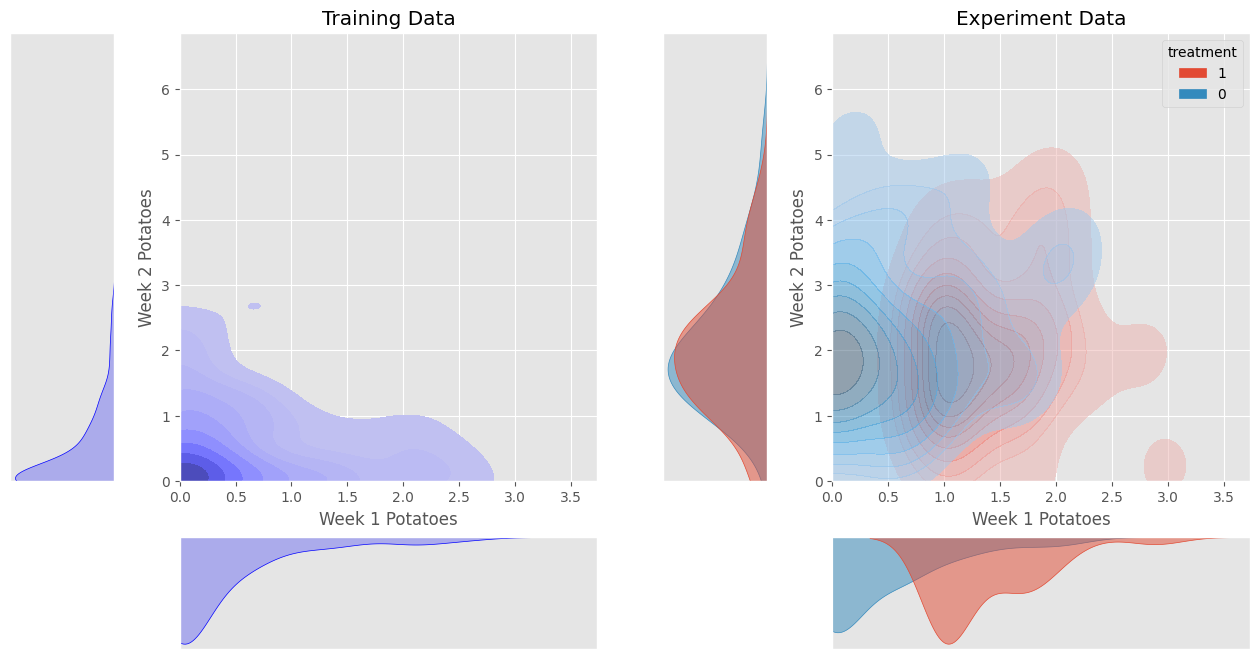

In [54]:
x = 'surrogate_0'
y = 'non_surrogate_1'
xlab = 'Week 1 Potatoes'
ylab = 'Week 2 Potatoes'

fig = plt.figure(figsize = (16, 8))

gridspec = fig.add_gridspec(
    nrows = 2,
    ncols = 4,
    width_ratios = [1, 4, 1, 4],
    height_ratios = [4, 1],
    wspace = 0.25
)

# for i in range(2):
#     for j in range(4):
#         ax = fig.add_subplot(gridspec[i, j])
#         ax.text(0.5, 0.5, f'({i}, {j})', ha='center', va='center', fontsize=12)
#         ax.set_xticks([])
#         ax.set_yticks([])


training_kde_ax = fig.add_subplot(gridspec[0, 1])
sns.kdeplot(
    data = training_data,
    x=x,
    y=y,
    clip = bounds,
    color='blue',
    fill = True,
    ax=training_kde_ax
)
training_kde_ax.set_title('Training Data')
training_kde_ax.set_xlabel(xlab)
training_kde_ax.set_ylabel(ylab)

training_kde_x_ax = fig.add_subplot(gridspec[1, 1], sharex=training_kde_ax)
sns.kdeplot(
    data = training_data,
    x=x,
    color='blue',
    clip = bounds[0],
    ax=training_kde_x_ax,
    fill = True
)
training_kde_x_ax.invert_yaxis()
training_kde_x_ax.axes.get_yaxis().set_visible(False)
training_kde_x_ax.axes.get_xaxis().set_visible(False)

training_kde_y_ax = fig.add_subplot(gridspec[0, 0], sharey=training_kde_ax)
sns.kdeplot(
    data = training_data,
    y=y,
    color='blue',
    clip = bounds[1],
    ax=training_kde_y_ax,
    fill = True
)
training_kde_y_ax.axes.get_yaxis().set_visible(False)
training_kde_y_ax.invert_xaxis()
training_kde_y_ax.axes.get_xaxis().set_visible(False)

experiment_kde_ax = fig.add_subplot(gridspec[0, 3], sharey=training_kde_ax, sharex=training_kde_ax)
sns.kdeplot(
    data = experiment_data,
    x=x,
    y=y,
    clip = bounds,
    # color='green',
    hue = 'treatment',
    hue_order=[1, 0],
    fill = True,
    common_norm=False,
    ax = experiment_kde_ax,
    alpha=0.5
)
experiment_kde_ax.set_title('Experiment Data')
experiment_kde_ax.set_xlabel(xlab)
experiment_kde_ax.set_ylabel(ylab)

experiment_kde_x_ax = fig.add_subplot(gridspec[1, 3], sharex=experiment_kde_ax)
sns.kdeplot(
    data = experiment_data,
    x=x,
    hue='treatment',
    hue_order=[1, 0],
    clip = bounds[1],
    ax=experiment_kde_x_ax,
    fill = True,
    common_norm=False,
    alpha=0.5,
    legend=False
)
experiment_kde_x_ax.invert_yaxis()
experiment_kde_x_ax.axes.get_yaxis().set_visible(False)
experiment_kde_x_ax.axes.get_xaxis().set_visible(False)

experiment_kde_y_ax = fig.add_subplot(gridspec[0, 2], sharey=experiment_kde_ax)
sns.kdeplot(
    data = experiment_data,
    y=y,
    hue='treatment',
    hue_order=[1, 0],
    clip = bounds[1],
    ax=experiment_kde_y_ax,
    fill = True,
    common_norm=False,
    alpha=0.5,
    legend=False
)
experiment_kde_y_ax.axes.get_yaxis().set_visible(False)
experiment_kde_y_ax.invert_xaxis()
experiment_kde_y_ax.axes.get_xaxis().set_visible(False)

# fig, ax = plt.subplots(figsize=(12, 6), ncols=2, sharey=True, sharex=True)
# sns.kdeplot(
#     data = training_data,
#     x=x,
#     y='non_surrogate_1',
#     clip = bounds,
#     color='blue',
#     fill = True,
#     ax=ax[0]
# )
# ax[0].set_title('Training Data')
# ax[0].set_xlabel(xlab)
# ax[0].set_ylabel('Week 2 Potatoes\n(Non-Surrogate)')
# sns.kdeplot(
#     data = experiment_data,
#     x=x,
#     y='non_surrogate_1',
#     hue='treatment',
#     clip = bounds,
#     color = 'green',
#     hue_order=[1, 0],
#     fill = True,
#     common_norm=False,
#     ax=ax[1],
#     alpha=0.5
# )
# ax[1].set_title('Experiment Data')
# ax[1].set_xlabel(xlab)
fig.savefig('../presentation/comparability_violation_1_4.png')

In [ ]:
# 